In [1]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.transforms as transforms
import matplotlib as mpl
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}

plt.rc('font', **font)
width  = 3.402
height = width / 1.2

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.learning.blr_slip import SlipBayesianLinearRegression, FullBodySlipBayesianLinearRegression
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *


from util.transform_algebra import *
from util.util_func import *

from sklearn import linear_model

3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]


In [2]:
# import all slip datasets

train_datasets = []
validate_datasets = []

dataset_paths = [] 
dataset_labels = []
dataset_paths.append('../data/ral2023_dataset/husky/boreal_snow/slip_dataset_all.pkl')
dataset_labels.append('H_snow')
dataset_paths.append('../data/ral2023_dataset/husky/grand_salon_tile_inflated/slip_dataset_all.pkl')
dataset_labels.append('H_tile')
dataset_paths.append('../data/ral2023_dataset/husky/grand_salon_left-deflated/slip_dataset_all.pkl')
dataset_labels.append('H_tile_ld')
dataset_paths.append('../data/ral2023_dataset/marmotte/boreal_snow/slip_dataset_all.pkl')
dataset_labels.append('M_snow')
# dataset_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_a/slip_dataset_all.pkl')
# dataset_labels.append('M_hard_snow_a')
dataset_paths.append('../data/ral2023_dataset/marmotte/grand_salon_tile_b/slip_dataset_all.pkl')
dataset_labels.append('M_tile')
dataset_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_b/slip_dataset_all.pkl')
dataset_labels.append('M_hard_snow')
dataset_paths.append('../data/ral2023_dataset/warthog_tracks/boreal_mud/slip_dataset_all.pkl')
dataset_labels.append('W_mud')
dataset_paths.append('../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/slip_dataset_all.pkl')
dataset_labels.append('W_crust')

for dataset_path in dataset_paths:
    full_dataset = pd.read_pickle(dataset_path)
    full_dataset_length = len(full_dataset)
    train_dataset = full_dataset[:int(full_dataset_length/2)]
    train_datasets.append(train_dataset)
    validate_dataset = full_dataset[int(full_dataset_length/2):]
    validate_datasets.append(validate_dataset)
    print(dataset_path)


# print(train_dataset)

../data/ral2023_dataset/husky/boreal_snow/slip_dataset_all.pkl
../data/ral2023_dataset/husky/grand_salon_tile_inflated/slip_dataset_all.pkl
../data/ral2023_dataset/husky/grand_salon_left-deflated/slip_dataset_all.pkl
../data/ral2023_dataset/marmotte/boreal_snow/slip_dataset_all.pkl
../data/ral2023_dataset/marmotte/grand_salon_tile_b/slip_dataset_all.pkl
../data/ral2023_dataset/marmotte/ga_hard_snow_b/slip_dataset_all.pkl
../data/ral2023_dataset/warthog_tracks/boreal_mud/slip_dataset_all.pkl
../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/slip_dataset_all.pkl


In [3]:
# import powertrain vels

cmd_left_str_list = []
cmd_right_str_list = []
for i in range(0, 40):
    str_cmd_left_i = 'cmd_left_' + str(i)
    str_cmd_right_i = 'cmd_right_' + str(i)
    cmd_left_str_list.append(str_cmd_left_i)
    cmd_right_str_list.append(str_cmd_right_i)
# cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
# cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()

encoder_left_str_list = []
encoder_right_str_list = []
for i in range(0, 40):
    str_encoder_left_i = 'left_wheel_vel_' + str(i)
    str_encoder_right_i = 'right_wheel_vel_' + str(i)
    encoder_left_str_list.append(str_encoder_left_i)
    encoder_right_str_list.append(str_encoder_right_i)
# encoder_left_vels_array = validate_dataset[encoder_left_str_list].to_numpy()
# encoder_right_vels_array = validate_dataset[encoder_right_str_list].to_numpy()

transitory_left_str_list = []
transitory_right_str_list = []
for i in range(0, 40):
    str_transitory_left_i = 'transitory_vel_left_' + str(i)
    str_transitory_right_i = 'transitory_vel_right_' + str(i)
    transitory_left_str_list.append(str_transitory_left_i)
    transitory_right_str_list.append(str_transitory_right_i)
# transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
# transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()

    

In [4]:
# extract cmd_body_vel arrays (input arrays)

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
# idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
# idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
# idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()

icp_x_str_list = []
icp_y_str_list = []
icp_z_str_list = []
icp_roll_str_list = []
icp_pitch_str_list = []
icp_yaw_str_list = []
for i in range(0, 40):
    str_icp_x_i = 'icp_interpolated_x_' + str(i)
    str_icp_y_i = 'icp_interpolated_y_' + str(i)
    str_icp_yaw_i = 'icp_interpolated_yaw_' + str(i)
    icp_x_str_list.append(str_icp_x_i)
    icp_y_str_list.append(str_icp_y_i)
    icp_yaw_str_list.append(str_icp_yaw_i)
# icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
# icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
# icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()

# extract icp vels

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
# icp_vel_x_array = validate_dataset[str_icp_vel_x_list].to_numpy()
# icp_vel_y_array = validate_dataset[str_icp_vel_y_list].to_numpy()
# icp_vel_yaw_array = validate_dataset[str_icp_vel_yaw_list].to_numpy()

# extract body_vel_distruptions arrays (output arrays)

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)
    
# body_vel_disturption_x_array = validate_dataset[str_body_vel_disturption_x_list].to_numpy()
# body_vel_disturption_y_array = validate_dataset[str_body_vel_disturption_y_list].to_numpy()
# body_vel_disturption_yaw_array = validate_dataset[str_body_vel_disturption_yaw_list].to_numpy()

In [5]:
# import models

blr_param_paths = []
blr_param_paths.append('../data/ral2023_dataset/husky/boreal_snow/trained_params/slip/blr/steady-state/')
blr_param_paths.append('../data/ral2023_dataset/husky/grand_salon_tile_inflated/trained_params/slip/blr/steady-state/')
blr_param_paths.append('../data/ral2023_dataset/husky/grand_salon_left-deflated/trained_params/slip/blr/steady-state/')
blr_param_paths.append('../data/ral2023_dataset/marmotte/boreal_snow/trained_params/slip/blr/steady-state/')
blr_param_paths.append('../data/ral2023_dataset/marmotte/grand_salon_tile_b/trained_params/slip/blr/steady-state/')
# blr_param_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_a/trained_params/slip/blr/steady-state/')
blr_param_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_b/trained_params/slip/blr/steady-state/')
blr_param_paths.append('../data/ral2023_dataset/warthog_tracks/boreal_mud/trained_params/slip/blr/steady-state/')
blr_param_paths.append('../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/trained_params/slip/blr/steady-state/')

# robot = 'husky'
robot = 'marmotte'
# robot = 'warthog-track'
if robot=='husky':
    wheel_radius = 0.33 / 2
    baseline = 0.55
    dt = 0.05
if robot=='marmotte':
    wheel_radius = 0.116
    baseline = 0.5927
    dt=0.05
if robot == 'warthog':
    wheel_radius = 0.3
    baseline = 1.1652
    dt = 0.05
    
slip_input_dimensions = 2
a_param_init = 0
b_param_init = 0
param_variance_init = 999999999999999999999
variance_init = 1000000000
kappa_param = 1
    
# ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt)
# full_body_slip_blr = FullBodySlipBayesianLinearRegression(1, 1, 3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
# full_body_slip_blr.load_params(blr_params_path)

# print(full_body_slip_blr.body_x_slip_blr.weights)

In [6]:
# compute M-RMSE


def compute_single_step_error(meas_state, pred_state):
    pred_error = meas_state - pred_state
    pred_error[2] = wrap2pi(pred_error[2]) # wrap yaw angle error to pi
    pred_error_squared_scalar = pred_error.T @ pred_error
    return np.sqrt(pred_error_squared_scalar)

def horizon_mrsme(meas_states, pred_states):
    n_predictions = meas_states.shape[0]
    prediction_error_sum = 0
    for i in range(0, n_predictions):
        prediction_error_sum += compute_single_step_error(meas_states[i], pred_states[i])
    return np.sqrt(prediction_error_sum / n_predictions)

window_size = 40

def compute_prediction_metrics(validate_dataset, robot, blr_param_path):
    n_test_windows = len(validate_dataset)
    
    cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
    cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()
    transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
    transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()
    idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
    idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
    idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()
    icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
    icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
    icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()
    body_vel_disturption_x_array = validate_dataset[str_body_vel_disturption_x_list].to_numpy()
    body_vel_disturption_y_array = validate_dataset[str_body_vel_disturption_y_list].to_numpy()
    body_vel_disturption_yaw_array = validate_dataset[str_body_vel_disturption_yaw_list].to_numpy()
    
    if robot=='H':
        wheel_radius = 0.33 / 2
        baseline = 0.55
        dt = 0.05
    if robot=='M':
        wheel_radius = 0.116
        baseline = 0.5927
        dt=0.05
    if robot == 'W':
        wheel_radius = 0.3
        baseline = 1.1652
        dt = 0.05
        
    slip_input_dimensions = 2
    a_param_init = 0
    b_param_init = 0
    param_variance_init = 999999999999999999999
    variance_init = 1000000000
    kappa_param = 1
    
    ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt)
    full_body_slip_blr = FullBodySlipBayesianLinearRegression(1, 1, 3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
    full_body_slip_blr.load_params(blr_param_path)
    
    blr_predictions = np.zeros((n_test_windows, window_size, 3))
    idd_predictions = np.zeros((n_test_windows, window_size, 3))
    cmd_input_horizon = np.zeros((2, window_size))
    transitory_input_horizon = np.zeros((2, window_size))
    cmd_body_vel_horizon = np.zeros((2, window_size))
    transitory_body_vel_horizon = np.zeros((3, window_size))
    blr_slip_body_vel_horizon = np.zeros((3, window_size))

    cmd_idd_horizon_prediction = np.zeros((3, window_size))
    transitory_idd_horizon_prediction = np.zeros((3, window_size))
    blr_slip_horizon_prediction = np.zeros((3, window_size))
    icp_horizon_meas = np.zeros((3, window_size))

    cmd_idd_prediction_errors = np.zeros(n_test_windows)
    transitory_idd_prediction_errors = np.zeros(n_test_windows)
    blr_slip_prediction_errors = np.zeros(n_test_windows)
    idd_body_vels_array = np.zeros((window_size, 3))
    blr_init_state_covariance = np.eye(3) * 0.1

    for j in range(0, n_test_windows):
        cmd_input_horizon[0, :] = cmd_left_vels_array[j, :]
        cmd_input_horizon[1, :] = cmd_right_vels_array[j, :]

        transitory_input_horizon[0, :] = transitory_left_vels_array[j, :]
        transitory_input_horizon[1, :] = transitory_right_vels_array[j, :]

        transitory_body_vel_horizon[0, :] = idd_body_vel_x_array[j, :]
        transitory_body_vel_horizon[1, :] = idd_body_vel_y_array[j, :]
        transitory_body_vel_horizon[2, :] = idd_body_vel_yaw_array[j, :]

        cmd_idd_horizon_prediction_error = 0
        transitory_idd_horizon_prediction_error = 0
        blr_horizon_prediction_error = 0

        for i in range(0, window_size-1):
            icp_2d_state = np.array([icp_x_array[j, i], icp_y_array[j, i], icp_yaw_array[j, i]])

            cmd_idd_horizon_prediction[:, i+1] = ideal_diff_drive.predict_2d(cmd_idd_horizon_prediction[:, i], cmd_input_horizon[:, i])
            cmd_idd_horizon_prediction_error += compute_single_step_error(icp_2d_state, cmd_idd_horizon_prediction[:, i])

            transitory_idd_horizon_prediction[:, i+1] = ideal_diff_drive.predict_2d(transitory_idd_horizon_prediction[:, i], transitory_input_horizon[:, i])
            transitory_idd_horizon_prediction_error += compute_single_step_error(icp_2d_state, transitory_idd_horizon_prediction[:, i])

        idd_body_vels_array[:, 0] = idd_body_vel_x_array[j, :]
        idd_body_vels_array[:, 1] = idd_body_vel_y_array[j, :]
        idd_body_vels_array[:, 2] = idd_body_vel_yaw_array[j, :]

        prediction_means, prediction_covariances = full_body_slip_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array, 
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)
        icp_horizon_meas[0, :] = icp_x_array[j, :]
        icp_horizon_meas[1, :] = icp_y_array[j, :]
        icp_horizon_meas[2, :] = icp_yaw_array[j, :]
        blr_prediction_errors = icp_horizon_meas - prediction_means

        for i in range(0, window_size):
            icp_2d_state = np.array([icp_x_array[j, i], icp_y_array[j, i], icp_yaw_array[j, i]])
            blr_horizon_prediction_error += compute_single_step_error(icp_2d_state, prediction_means[:, i])

        # blr_msre = np.diag(blr_prediction_errors @ blr_prediction_errors.T)
        # blr_slip_prediction_errors[j] = np.sqrt(np.sqrt((blr_msre.T @ blr_msre) / window_size))

        # print('blr : ', prediction_means[2, -1])
        # print('icp : ', icp_horizon_meas[2, -1])


        cmd_idd_prediction_errors[j] = cmd_idd_horizon_prediction_error / window_size
        transitory_idd_prediction_errors[j] = transitory_idd_horizon_prediction_error / window_size
        blr_slip_prediction_errors[j] = blr_horizon_prediction_error / window_size
        
    return cmd_idd_prediction_errors, transitory_idd_prediction_errors, blr_slip_prediction_errors
    
cmd_idd_prediction_errors_list = []
transitory_idd_prediction_errors_list = []
blr_slip_prediction_errors_list = []
for i in range(len(validate_datasets)):
    validate_dataset = validate_datasets[i]
    dataset_label = dataset_labels[i]
    robot = dataset_label.split('_')[0]
    blr_param_path = blr_param_paths[i]
    
    cmd_idd_prediction_errors, transitory_idd_prediction_errors, blr_slip_prediction_errors = compute_prediction_metrics(validate_dataset, robot, blr_param_path)
    cmd_idd_prediction_errors_list.append(cmd_idd_prediction_errors)
    transitory_idd_prediction_errors_list.append(transitory_idd_prediction_errors)
    blr_slip_prediction_errors_list.append(blr_slip_prediction_errors)
    print(robot)

H
H
H
M
M
M
W
W


/tmp/ipykernel_298999/1401431212.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


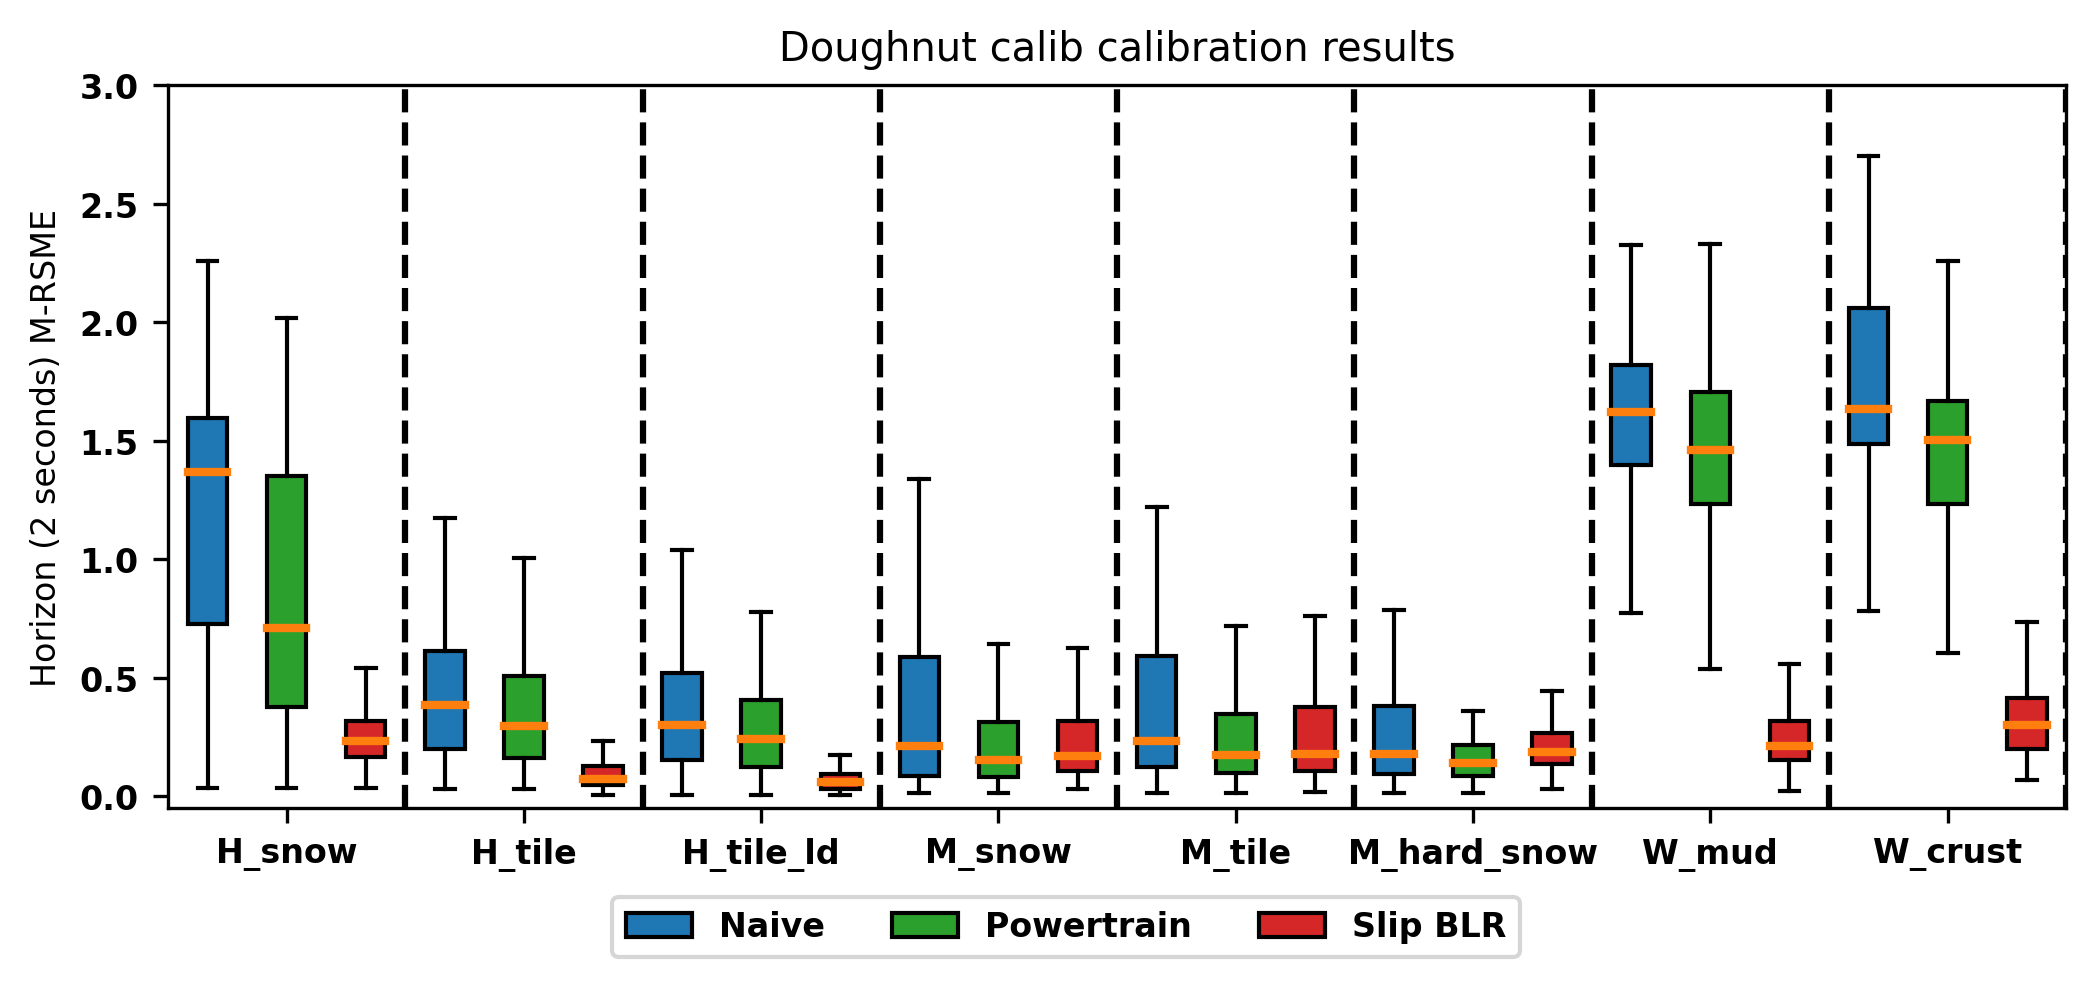

In [7]:
fig, ax = plt.subplots(1, 1, dpi=300, gridspec_kw={'hspace': 0.35, 'wspace': 0.23})
fig.set_size_inches(2*width, height)
fig.subplots_adjust(left=.06, bottom=.14, right=.99, top=.99)
fig.tight_layout()

medians_color = 'C1'
cmd_box_color = 'C0'
powertrain_box_color = 'C2'
blr_slip_box_color = 'C3'
boxplots_width = 0.5

y_max = 3.0
y_min = -0.05

for i in range(len(validate_datasets)):
    # print(cmd_idd_prediction_errors_list[i])
    cmd = ax.boxplot(cmd_idd_prediction_errors_list[i], positions = [3*i], widths=boxplots_width, showfliers=False, patch_artist=True, 
                   boxprops=dict(facecolor = cmd_box_color, color = 'k'),
                   whiskerprops=dict(color='k'), 
                   medianprops=dict(color=medians_color, linewidth=2))
    
    pwrtrn = ax.boxplot(transitory_idd_prediction_errors_list[i], positions = [3*i+1], widths=boxplots_width, showfliers=False, patch_artist=True, 
                   boxprops=dict(facecolor = powertrain_box_color, color = 'k'),
                   whiskerprops=dict(color='k'), 
                   medianprops=dict(color=medians_color, linewidth=2))
    
    blr_slip = ax.boxplot(blr_slip_prediction_errors_list[i], positions = [3*i+2], widths=boxplots_width, showfliers=False, patch_artist=True, 
                   boxprops=dict(facecolor = blr_slip_box_color, color = 'k'),
                   whiskerprops=dict(color='k'), 
                   medianprops=dict(color=medians_color, linewidth=2))
    
    ax.vlines(3*i+2.5, y_min, y_max, colors='k', linestyles='dashed')
    
ax.set_ylim(y_min, y_max)
    
xticks = []
for i in range(len(dataset_labels)):
    xticks.append(3*i+1)
ax.set_xticks(xticks)
ax.set_xticklabels(dataset_labels)
ax.set_ylabel('Horizon (2 seconds) M-RSME')
ax.set_title('Doughnut calib calibration results')

# legend
legend_elements = [Rectangle((0,0), width=5, height=3, facecolor='C0', label='Naive', linestyle='solid', edgecolor='k'),
                   Rectangle((0,0), width=5, height=3, facecolor='C2', label='Powertrain', linestyle='solid', edgecolor='k'), 
                  Rectangle((0,0), width=5, height=3, facecolor='C3', label='Slip BLR', linestyle='solid', edgecolor='k')]

fig.legend(handles=legend_elements, loc='center', ncol=3, bbox_to_anchor=(0.5,0))

In [ ]:
# evaluate error with respect to number of training timesteps

validate_dataset = validate_datasets[0]
train_dataset = train_datasets[0]
n_test_windows = len(validate_dataset)

full_body_slip_blr = FullBodySlipBayesianLinearRegression(1, 1, 3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)

saved_params_root_path = '../data/ral2023_dataset/husky/boreal_snow/trained_params/slip/blr/steady-state/growing_training_set/'

blr_slip_prediction_errors_training_timesteps_list = []

cmd_left_vels_array = validate_dataset[cmd_left_str_list].to_numpy()
cmd_right_vels_array = validate_dataset[cmd_right_str_list].to_numpy()
transitory_left_vels_array = validate_dataset[transitory_left_str_list].to_numpy()
transitory_right_vels_array = validate_dataset[transitory_right_str_list].to_numpy()
idd_body_vel_x_array = validate_dataset[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = validate_dataset[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = validate_dataset[idd_body_vel_yaw_str_list].to_numpy()
icp_x_array = validate_dataset[icp_x_str_list].to_numpy()
icp_y_array = validate_dataset[icp_y_str_list].to_numpy()
icp_yaw_array = validate_dataset[icp_yaw_str_list].to_numpy()
body_vel_disturption_x_array = validate_dataset[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = validate_dataset[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = validate_dataset[str_body_vel_disturption_yaw_list].to_numpy()

idd_body_vels_array = np.zeros((window_size, 3))
blr_slip_horizon_prediction = np.zeros((3, window_size))
blr_init_state_covariance = np.zeros((3,3))
# translation_init_covariance = 0.005
# rotation_init_covariance = 0.05
translation_init_covariance = 0.01
rotation_init_covariance = 0.03
blr_init_state_covariance[0,0] = translation_init_covariance
blr_init_state_covariance[1,1] = translation_init_covariance
blr_init_state_covariance[2,2] = rotation_init_covariance
blr_slip_prediction_z_scores_translational = np.zeros(n_test_windows)
blr_slip_prediction_z_scores_rotational = np.zeros(n_test_windows)

for i in range(3, len(train_dataset)):
    print(str(i) + ' / ' + str(len(train_dataset)))
    robot = 'H'
    blr_param_path = saved_params_root_path + str(i) + '/'
    # cmd_idd_prediction_errors, transitory_idd_prediction_errors, blr_slip_prediction_errors = compute_prediction_metrics(validate_dataset, robot, blr_param_path)
    # blr_slip_prediction_errors_training_timesteps_list.append(blr_slip_prediction_errors)
    
    n_test_windows = len(validate_dataset)
    
    blr_slip_prediction_errors = np.zeros(n_test_windows)
    
    if robot=='H':
        wheel_radius = 0.33 / 2
        baseline = 0.55
        dt = 0.05
    if robot=='M':
        wheel_radius = 0.116
        baseline = 0.5927
        dt=0.05
    if robot == 'W':
        wheel_radius = 0.3
        baseline = 1.1652
        dt = 0.05
        
    slip_input_dimensions = 2
    a_param_init = 0
    b_param_init = 0
    param_variance_init = 999999999999999999999
    variance_init = 1000000000
    kappa_param = 2
    
    icp_horizon_meas = np.zeros((3, window_size))
    
    ideal_diff_drive = Ideal_diff_drive(wheel_radius, baseline, dt)
    full_body_slip_blr = FullBodySlipBayesianLinearRegression(1, 1, 3, a_param_init, b_param_init, param_variance_init, variance_init, baseline, wheel_radius, dt, kappa_param)
    full_body_slip_blr.load_params(blr_param_path)
    print('weights_x : ', full_body_slip_blr.body_x_slip_blr.weights)
    print('weights_y : ', full_body_slip_blr.body_y_slip_blr.weights)
    print('weights_yaw : ', full_body_slip_blr.body_yaw_slip_blr.weights)
    
    for j in range(0, n_test_windows):

        blr_horizon_prediction_error = 0

        idd_body_vels_array[:, 0] = idd_body_vel_x_array[j, :]
        idd_body_vels_array[:, 1] = idd_body_vel_y_array[j, :]
        idd_body_vels_array[:, 2] = idd_body_vel_yaw_array[j, :]

        prediction_means, prediction_covariances = full_body_slip_blr.predict_horizon_from_body_idd_vels(idd_body_vels_array, 
                                                                                                        blr_slip_horizon_prediction[:, 0], blr_init_state_covariance)
        for i in range(0, window_size):
            icp_2d_state = np.array([icp_x_array[j, i], icp_y_array[j, i], icp_yaw_array[j, i]])
            blr_horizon_prediction_error += compute_single_step_error(icp_2d_state, prediction_means[:, i])
            
        blr_slip_prediction_errors[j] = blr_horizon_prediction_error / window_size
    blr_slip_prediction_errors_training_timesteps_list.append(blr_slip_prediction_errors)
    

3 / 301
weights_x :  [[0.33591697]]
weights_y :  [[0.06523464]]
weights_yaw :  [[ 0.15300858]
 [-0.03002761]
 [ 0.76214958]]
4 / 301
weights_x :  [[0.33582406]]
weights_y :  [[0.06361602]]
weights_yaw :  [[ 0.16462804]
 [-0.00479816]
 [ 0.790674  ]]
5 / 301
weights_x :  [[0.33592743]]
weights_y :  [[0.06398933]]
weights_yaw :  [[ 0.16586636]
 [-0.00118324]
 [ 0.79499035]]
6 / 301
weights_x :  [[0.30469988]]
weights_y :  [[0.08197081]]
weights_yaw :  [[ 1.66340501e-01]
 [-1.14056433e-04]
 [ 7.94999337e-01]]
7 / 301
weights_x :  [[0.3075885]]
weights_y :  [[0.07664898]]
weights_yaw :  [[ 1.93077626e-01]
 [-5.98908827e-04]
 [ 8.09317260e-01]]
8 / 301
weights_x :  [[0.27060628]]
weights_y :  [[-0.02289353]]
weights_yaw :  [[0.17925088]
 [0.00901087]
 [0.8086744 ]]
9 / 301
weights_x :  [[0.27123085]]
weights_y :  [[-0.02289217]]
weights_yaw :  [[0.17925667]
 [0.01058705]
 [0.80856469]]
10 / 301
weights_x :  [[0.30321645]]
weights_y :  [[0.01615011]]
weights_yaw :  [[0.12724631]
 [0.0771013 

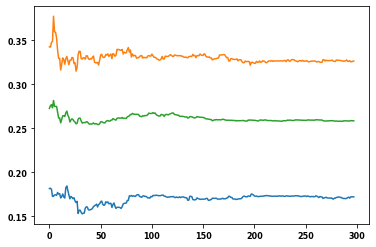

In [25]:
# weights_x :  [[-0.12538497]]
# weights_y :  [[-0.01996453]]
# weights_yaw :  [[ 0.31519004]
#  [-2.05371261]
#  [ 0.28661516]]

blr_training_timesteps_means = np.zeros(len(blr_slip_prediction_errors_training_timesteps_list))
blr_training_timesteps_first_quantiles = np.zeros(len(blr_slip_prediction_errors_training_timesteps_list))
blr_training_timesteps_third_quantiles = np.zeros(len(blr_slip_prediction_errors_training_timesteps_list))

for i in range(len(blr_slip_prediction_errors_training_timesteps_list)):
    blr_training_timesteps_means[i] = np.mean(blr_slip_prediction_errors_training_timesteps_list[i])
    blr_training_timesteps_first_quantiles[i] = np.quantile(blr_slip_prediction_errors_training_timesteps_list[i], 0.25)
    blr_training_timesteps_third_quantiles[i] = np.quantile(blr_slip_prediction_errors_training_timesteps_list[i], 0.75)
    
plt.plot(blr_training_timesteps_first_quantiles)
plt.plot(blr_training_timesteps_third_quantiles)
plt.plot(blr_training_timesteps_means)

# plt.ylim(0.2, 0.3)

In [23]:
print(np.max(blr_slip_prediction_errors_training_timesteps_list[0]))

0.9662788192652224
